In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import caffe
import scipy.misc

In [2]:
from imret.dataset import dataset

In [5]:
image = cv2.imread('../data/images/a_abbey_abbey_000001.jpg')

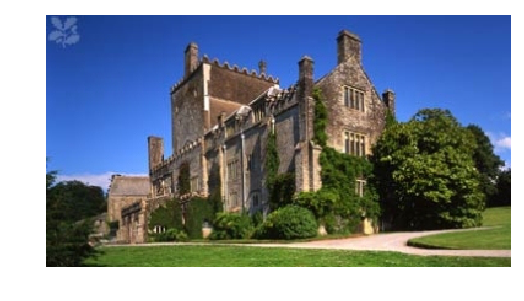

In [6]:
plt.axis('off')
plt.imshow(image[:, :, (2, 1, 0)])

In [15]:
ground_truth = cv2.imread('../data/imgs/labels/a_abbey_abbey_000001.png')
print ground_truth.shape

(384, 384, 3)


In [16]:
from imret.preprocess import Segment

In [63]:
net = Segment('../data/model/deploy.prototxt',
              '../data/model/snapshot.caffemodel',
              '../data/query/name_conversion.csv', gpu=False)

Creating net with: 
../data/model/deploy.prototxt 
../data/model/snapshot.caffemodel


In [64]:
palette = net.segmentation(image[:, :, (2, 1, 0)], threshold=0.8)

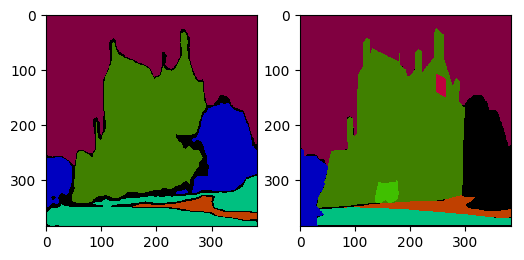

In [65]:
plt.subplot(121)
plt.imshow(palette)
plt.subplot(122)
plt.imshow(ground_truth[:, :, (2, 1, 0)])

In [66]:
np.unique(ground_truth)

array([  0,  64, 128, 192], dtype=uint8)

In [13]:
from imret.dataset import Dataset

In [14]:
dset = Dataset('../data/datasets/', 'test', '../data/images/')

In [20]:
dset.ground_truth('a_abbey_abbey_000001.jpg').keys()

[u'building',
 u'plant',
 u'tree8',
 u'tree',
 u'grass7',
 u'sky',
 u'tree3',
 u'window',
 u'tree4',
 u'path',
 u'grass']

In [21]:
size = (384, 384)
def create_label(scale, ground_truth, rgb=True):
    if rgb:
        label = np.zeros((w, h, 3), dtype=np.uint8)
    else:
        label = np.zeros((w, h), dtype=np.uint8)

    for (classname, contour) in ground_truth.items():
        try:
            color = net.color_palette[classname] if rgb else net.color_palette.class_id(classname)
            print(classname, color)
        except ValueError:
            continue

        cnt = contour * scale
        cv2.drawContours(label, [cnt.astype(np.int32)], -1, color, -1)
    return label

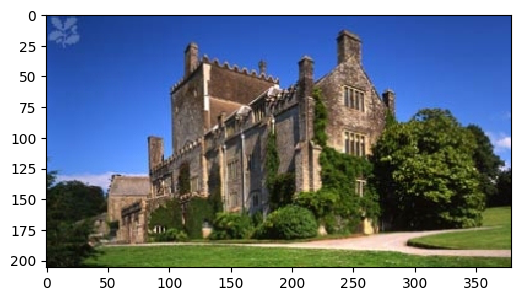

In [22]:
image = dset.get_im_array('a_abbey_abbey_000001.jpg', True)
plt.imshow(image)

In [24]:
w, h = size
w1, h1 = image.shape[:2]
fy = w / float(w1)
fx = h / float(h1)
scale = np.array([fx, fy])

(u'building', 10)
(u'plant', 26)
(u'tree', 36)
(u'sky', 33)
(u'window', 41)
(u'path', 25)
(u'grass', 22)


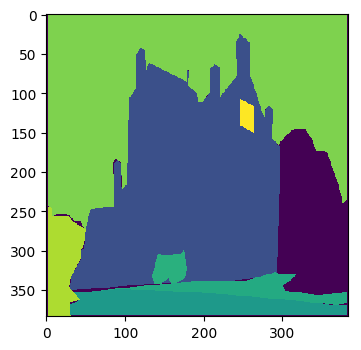

In [25]:
label = create_label(scale, dset.ground_truth('a_abbey_abbey_000001.jpg'), rgb=False)
plt.imshow(label)

In [26]:
print net.color_palette.class_id('desk'), net.color_palette.class_id('chair')
print net.color_palette.color_from_id(16), net.color_palette.color_from_id(12)

16 12
[ 0 64  0] [ 64   0 128]


In [27]:
i1 = net.segmentation(image, False, threshold=0.8)
print np.unique(i1)

[ 0 10 22 33 36]


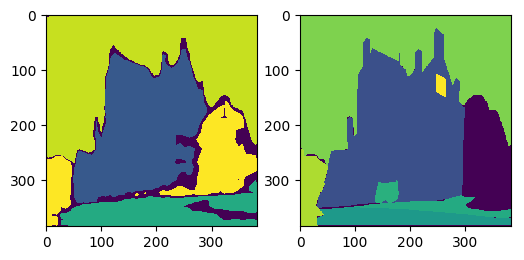

In [28]:
plt.subplot(121)
plt.imshow(i1)
plt.subplot(122)
plt.imshow(label)

In [29]:
weighted = net.weighted_image(image[:, :, (2, 1, 0)])

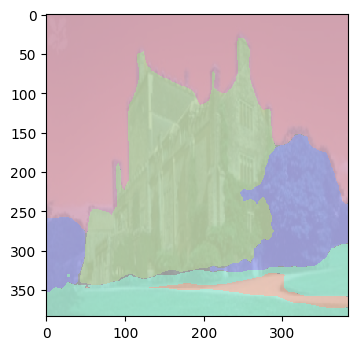

In [30]:
plt.imshow(weighted[:, :, (2, 1, 0)], alpha=.4)

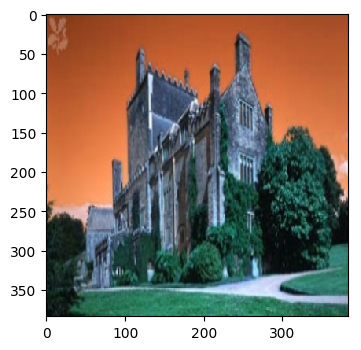

In [31]:
rsz = scipy.misc.imresize(image, (384, 384))
plt.imshow(rsz[:, :, (2, 1, 0)])

__background__
building
grass
sky
tree


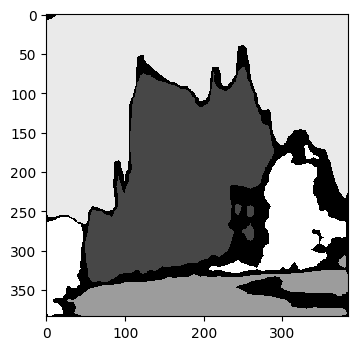

In [32]:
segmented = net.segmentation(image, return_paletted=False, threshold=0.9)
for label in np.unique(segmented):
    print net.color_palette.get_name(label)
plt.imshow(segmented, cmap='gray')

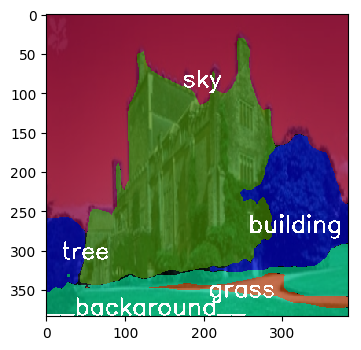

In [33]:
w = weighted.copy()
for obj in np.unique(segmented):
    objname = net.color_palette.get_name(obj)
    r, g, b = net.color_palette['building']
    name = [label for label in net.color_palette.names if all(net.color_palette[label] == [r, g, b])]
    
    tmp = np.zeros(segmented.shape, dtype=segmented.dtype)
    x, y = np.where(segmented == obj)
    tmp[x, y] = 255
    
    _, thresh = cv2.threshold(tmp.astype(np.float32), 127, 255, 0)
    _, cnt, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     bbox = cv2.boundingRect(cnt[0])
#     coords = tuple((bbox[0] + (bbox[2] / 2), bbox[1] + (bbox[3] / 2)))
    m = cv2.moments(cnt[0], False)
    try:
        coords = tuple((int(m['m10']/m['m00']), int(m['m01']/m['m00'])))
        cv2.putText(w, objname, coords, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    except ZeroDivisionError:
        pass
plt.imshow(w[:, :, (2, 1, 0)])
    

In [58]:
def create_mask(image, pixel_value, color):
    w, h = image.shape
    m1 = np.zeros((w, h), dtype=image.dtype)
    m2 = np.zeros((w, h, 3), dtype=image.dtype)

    x, y = np.where(image == pixel_value)
    m1[x, y] = 1
    m2[x, y, :] = color
    return m1, m2

In [59]:
import itertools
import scipy.misc

alpha = 0.4
images = []
image_ = scipy.misc.imresize(image, segmented.shape) #, interp='bilinear')

for (x1, x2) in itertools.permutations(np.unique(segmented), 2):
    mask1, overlay1 = create_mask(segmented, x1, color=(255, 0, 0))
    mask2, overlay2 = create_mask(segmented, x2, color=(0, 0, 255))
    
    img1 = cv2.bitwise_and(image_, image_, mask=mask1.astype(image_.dtype))
    img2 = cv2.bitwise_and(image_, image_, mask=mask2.astype(image_.dtype))
    img = cv2.bitwise_or(img1, img2)
    cv2.addWeighted(overlay1.astype(np.uint8), alpha, img, 1 - alpha, 0, img)
    cv2.addWeighted(overlay2.astype(np.uint8), alpha, img, 1 - alpha, 0, img)
    images.append((img, (x1, x2)))

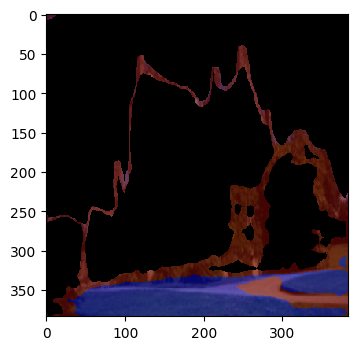

In [61]:
plt.imshow(images[1][0])

In [50]:
print len(list(itertools.permutations(np.unique(segmented), 2)))

20


In [51]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
#     data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    return data

In [38]:
output = np.array([img for (img, _) in images])
n = int(np.ceil(np.sqrt(output.shape[0])))
print n
padding = (((0, n ** 2 - output.shape[0]),  
            (0, 1), (0, 1))                 # add some space between filters
            + ((0, 0),) * (output.ndim - 3))
data = np.pad(output, padding, mode='constant', constant_values=255)
print data.shape, data.ndim
data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
print data.shape
data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
print data.shape

5
(25, 385, 385, 3) 4
(5, 385, 5, 385, 3)
(1925, 1925, 3)


In [47]:
vis_square(images)

AttributeError: 'list' object has no attribute 'shape'

In [39]:
4 * 385, 4 * 385

(1540, 1540)

True

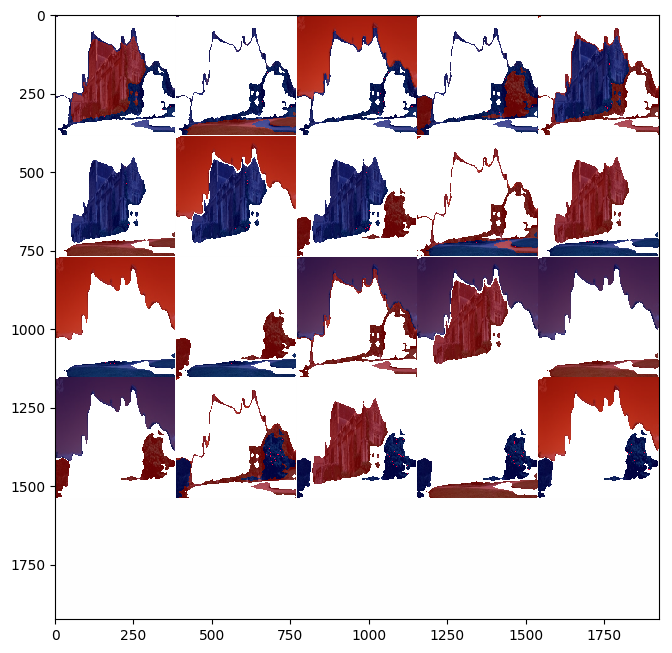

In [42]:
plt.figure(figsize=(12, 8))
plt.imshow(data[:, :, (2, 1, 0)] + 255)
cv2.imwrite("pairs.png", data[:1540, :, :])
# cv2.imwrite("mpairs.png", data[:1540, :1540, :])

In [127]:
len(images)

90

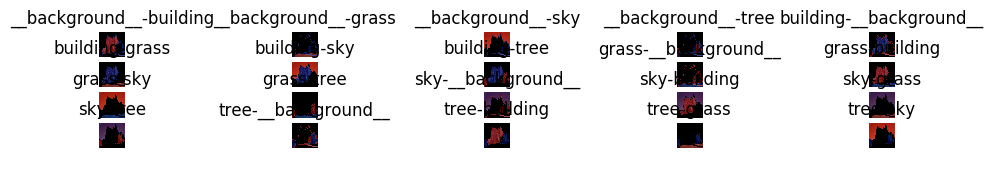

In [41]:

plt.figure(figsize=(12, 8))
for idx, (img, (n1, n2)) in enumerate(images):
    plt.subplot(20, 5, idx + 1)
    plt.axis('off')
    plt.title("{}-{}".format(net.color_palette.get_name(n1),
                             net.color_palette.get_name(n2)))
    plt.imshow(img[:, :, (2, 1, 0)])

In [129]:
prep_net = caffe.Net('../data/models/preposition/deploy.prototxt',
                     '../data/models/preposition/snapshot.caffemodel',
                     caffe.TEST)

In [130]:
with open('../data/models/preposition/mean.binaryproto', 'rb') as f:
    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.MergeFromString(f.read())
    mean_image = np.reshape(blob.data, (3, 256, 256))
    data_shape = tuple((1, 3, 227, 227))
    assert len(data_shape) == 4, 'Bad data shape.'
    mean_image = mean_image.astype(np.uint8)
    mean_image = mean_image.transpose(1, 2, 0)
    shape = list(mean_image.shape)
    mean_image = scipy.misc.imresize(mean_image, (data_shape[2], data_shape[3]))
    mean_image = mean_image.transpose(2, 0, 1)
    mean_image = mean_image.astype('float')
        
transformer = caffe.io.Transformer({'data': prep_net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_channel_swap('data', (2, 1, 0))
transformer.set_mean('data', mean_image)

In [131]:
_, channels, w, h = prep_net.blobs['data'].data.shape
prep_net.blobs['data'].reshape(len(images), channels, w, h)

In [132]:
for idx1, (im, _) in enumerate(images):
    transformed_image = transformer.preprocess('data', im)
    prep_net.blobs['data'].data[idx1] = transformed_image

/Users/danilonunes/.virtualenvs/imret2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [133]:
%time output = prep_net.forward()
output_prob = output['softmax']

CPU times: user 5.62 s, sys: 906 ms, total: 6.52 s
Wall time: 2.87 s


In [134]:
with open('../data/models/preposition/labels.txt') as fp:
    labels = [line.strip().replace('_', ' ') for line in fp.readlines()]
    
prepositions = []
scores = []
for idx2, prob in enumerate(output_prob):
    prep = labels[prob.argmax()]
    prepositions.append(prep)
    score = prob.max()
    scores.append(score)

In [136]:
for idx, (img, (n1, n2)) in enumerate(images):
    if net.color_palette.get_name(n1) == 'water':
        print "{}-{}-{}".format(net.color_palette.get_name(n1), 
                                prepositions[idx], 
                                net.color_palette.get_name(n2))

water-on-building
water-on-floor
water-on-ground
water-on-plant
water-on-road
water-on-rock
water-above-sky
water-on-tree
water-on-wall


In [91]:
from imret.topology import topology_relation

topology = []
for (i1, i2) in itertools.permutations(np.unique(segmented), 2):
    im1 = np.zeros(segmented.shape, dtype=np.uint8)
    im2 = np.zeros(segmented.shape, dtype=np.uint8)
    x1, y1 = np.where(segmented == i1)
    x2, y2 = np.where(segmented == i2)
    im1[x1, y1] = 255.
    im2[x2, y2] = 255.
    _, contour1, _ = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _, contour2, _ = cv2.findContours(im2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    relation = topology_relation((384, 384), {net.color_palette.get_name(i1): contour1[0], 
                                              net.color_palette.get_name(i2): contour2[0]})
    topology.append(relation[0]['relation'])

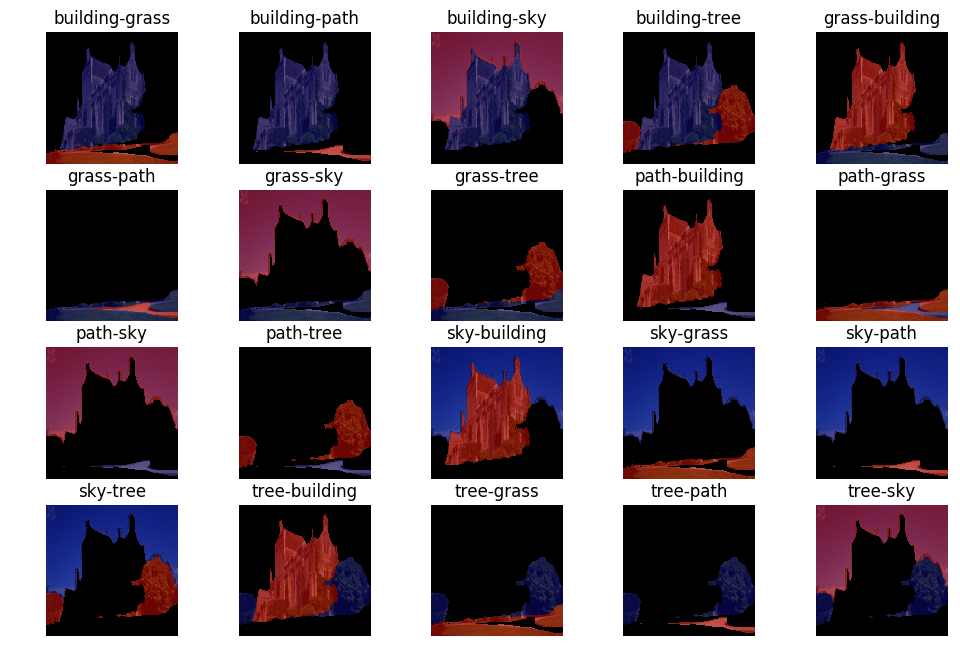

In [76]:
plt.figure(figsize=(12, 8))
for idx, (img, (n1, n2)) in enumerate(images):
    plt.subplot(4, 5, idx + 1)
    plt.axis('off')
    plt.title("{}-{}".format(net.color_palette.get_name(n1),
                             net.color_palette.get_name(n2)))
    plt.imshow(img[:, :, (2, 1, 0)])

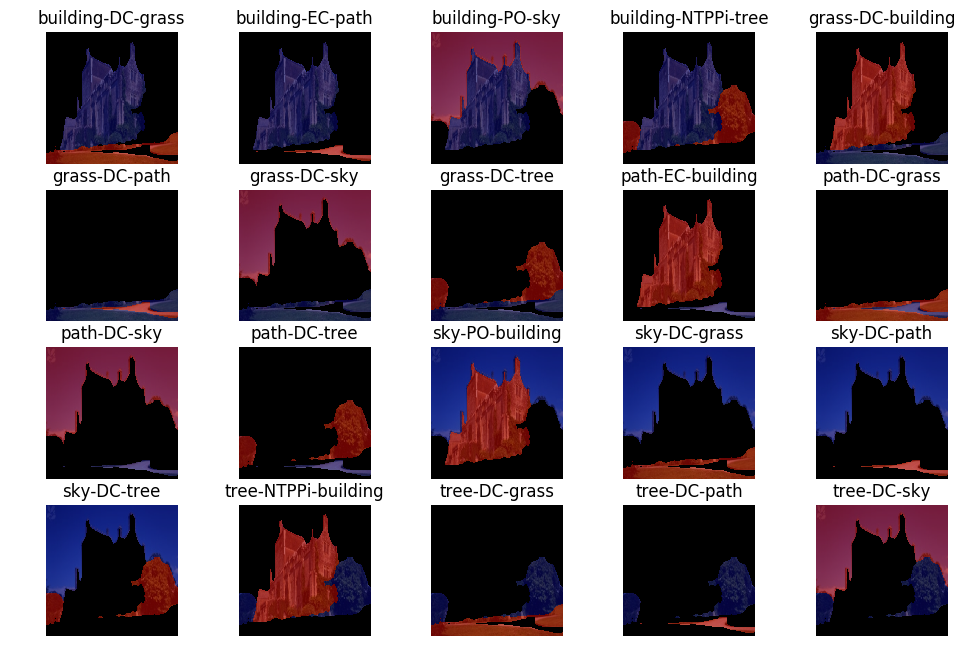

In [94]:
plt.figure(figsize=(12, 8))
for idx, (img, (n1, n2)) in enumerate(images):
    plt.subplot(4, 5, idx + 1)
    plt.axis('off')
    plt.title("{}-{}-{}".format(net.color_palette.get_name(n1),
                                topology[idx],
                                net.color_palette.get_name(n2)))
    plt.imshow(img[:, :, (2, 1, 0)])

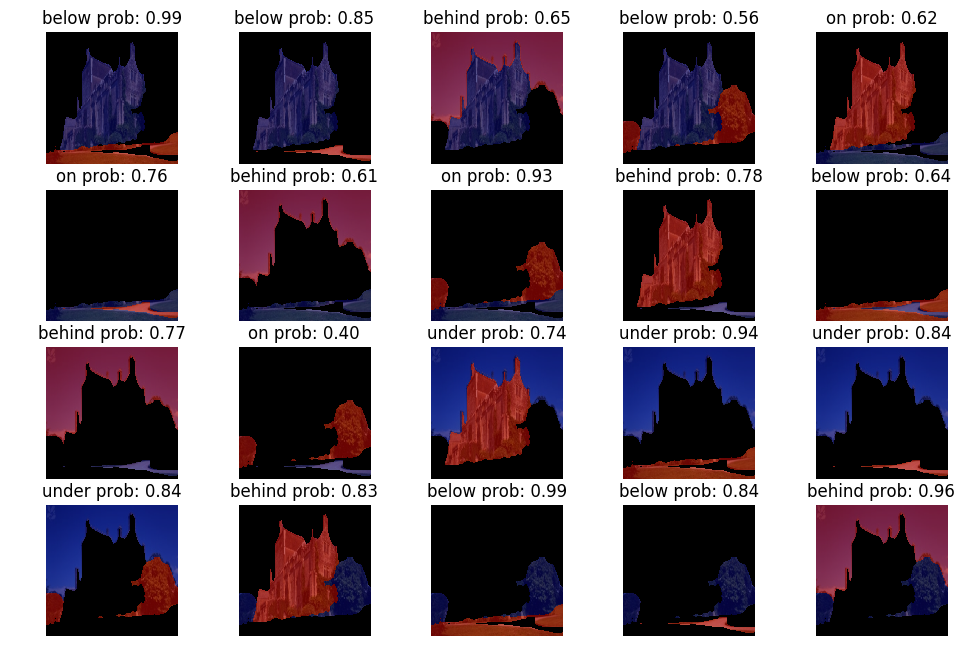

In [74]:
plt.figure(figsize=(12, 8))
for (idx, (img, (n1, n2))) in enumerate(images):
    plt.subplot(4, 5, idx + 1)
    plt.axis('off')
    plt.title("{} prob: {:.2f}".format(prepositions[idx], scores[idx]))
    plt.imshow(img[:, :, (2, 1, 0)])

In [18]:
segmented2 = cv2.imread('../data/segmented/a_access_road_access_road_000781.png', 0)
# segmented2 = cv2.imread('../data/segmented/z_zoo_zoological_garden_000173.png')
print segmented2.shape

(384, 384)


In [174]:
cv2.imwrite('img.png', segmented)

True

In [167]:
np.unique(segmented)

array([10, 22, 25, 33, 36])

In [16]:
np.unique(segmented2)

array([10, 23, 29, 32, 33, 36, 39, 40], dtype=uint8)

In [172]:
a = segmented2.reshape(-1, 3)
b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
_, idx = np.unique(b, return_index=True)

unique_a = a[idx]

In [173]:
unique_a

array([[  2,   2,   2],
       [  3,   3,   3],
       [  5,   5,   5],
       [ 10,  10,  10],
       [ 14,  14,  14],
       [ 18,  18,  18],
       [ 53,  53,  53],
       [ 96,  96,  96],
       [105, 105, 105],
       [135, 135, 135]], dtype=uint8)

In [67]:
pairs = cv2.imread('/Users/danilonunes/workspace/thesis/mainmatter/data/method/pairs.png')

In [70]:
pairs += 255

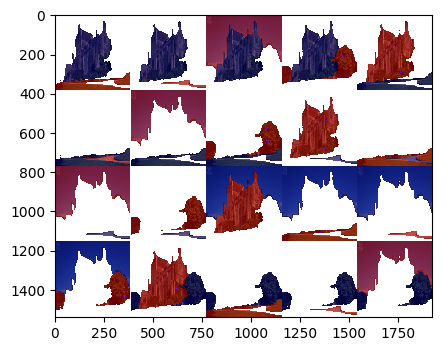

In [71]:
plt.imshow(pairs[:, :, (2, 1, 0)])

In [72]:
cv2.imwrite('/Users/danilonunes/Desktop/pairs.png', pairs)

True